# Movie Rating Prediction With Python

## Importing required libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Pre-processing

In [77]:
ds = pd.read_csv("IMDb_Movies_India.csv", encoding='latin1')

In [78]:
ds.head(4)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor


In [79]:
ds.shape

(15509, 10)

In [80]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


### Data Cleaning

In [81]:
ds.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

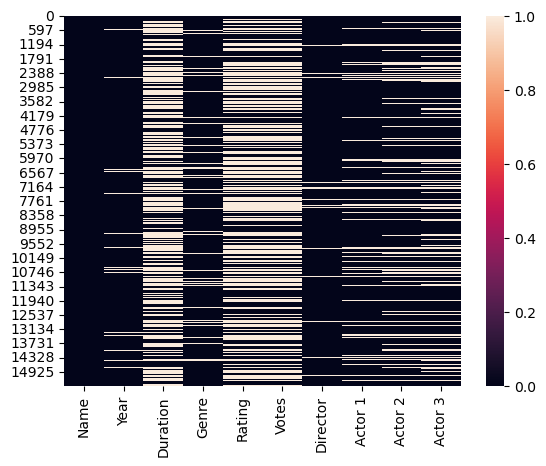

In [82]:
sns.heatmap(ds.isnull());

In [83]:
missing_count = ds.isnull().sum().sort_values(ascending=False)
missing_percent = (round(ds.isnull().sum()/ds.isnull().count(), 4)*100).sort_values(ascending=False)
missing_data = pd.concat([missing_count, missing_percent], 
                       axis=1, 
                       keys=['missing_count', 'missing_percent'])
missing_data

,missing_count,missing_percent
Duration,8269,53.32
Rating,7590,48.94
Votes,7589,48.93
Actor 3,3144,20.27
Actor 2,2384,15.37
Genre,1877,12.10
Actor 1,1617,10.43
Year,528,3.40
Director,525,3.39
Name,0,0.00


In [84]:
ds.dropna(subset=['Rating'], inplace=True)

(round(ds.isnull().sum()/ds.isnull().count(), 4)*100).sort_values(ascending=False)

Duration    26.11
Actor 3      3.69
Actor 2      2.53
Actor 1      1.58
Genre        1.29
Director     0.06
Name         0.00
Year         0.00
Rating       0.00
Votes        0.00
dtype: float64

In [85]:
ds.dropna(subset=['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], inplace=True)

(round(ds.isnull().sum()/ds.isnull().count(), 4)*100).sort_values(ascending=False)

Duration    25.13
Name         0.00
Year         0.00
Genre        0.00
Rating       0.00
Votes        0.00
Director     0.00
Actor 1      0.00
Actor 2      0.00
Actor 3      0.00
dtype: float64

In [86]:
ds['Duration'] = pd.to_numeric(ds['Duration'].str.strip(' min'))
ds['Duration'].fillna(ds['Duration'].mean(), inplace=True)

ds.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [87]:
ds.drop_duplicates(inplace=True)
ds.shape

(7558, 10)

In [88]:
ds['Year'] = ds['Year'].apply(lambda x: x.split(')')[0])

year_lst = []
for val in ds['Year']:
    if len(val.split('(')) == 1:
        year_lst.append(val.split('(')[0])
    elif len(val.split('(')) > 1:
        year_lst.append(val.split('(')[1])
ds['Year'] = year_lst

In [89]:
ds['Votes'] = ds['Votes'].str.replace(',', '').astype(int)
ds['Year'] = ds['Year'].astype(int)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7558 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7558 non-null   object 
 1   Year      7558 non-null   int32  
 2   Duration  7558 non-null   float64
 3   Genre     7558 non-null   object 
 4   Rating    7558 non-null   float64
 5   Votes     7558 non-null   int32  
 6   Director  7558 non-null   object 
 7   Actor 1   7558 non-null   object 
 8   Actor 2   7558 non-null   object 
 9   Actor 3   7558 non-null   object 
dtypes: float64(2), int32(2), object(6)
memory usage: 590.5+ KB


In [90]:
ds['Year'].unique()

array([2019, 1997, 2005, 2012, 2014, 2004, 2016, 1991, 2018, 2010, 1958,
       2021, 2017, 2009, 1993, 2002, 1946, 2008, 1994, 2007, 2013, 2003,
       1998, 1979, 1974, 2015, 2006, 1981, 2020, 1985, 2011, 1988, 1995,
       1987, 1999, 1973, 1968, 1953, 1986, 1982, 1977, 1950, 1969, 1948,
       1967, 1970, 1990, 1989, 1947, 2001, 2000, 1971, 1978, 1944, 1963,
       1992, 1976, 1984, 1975, 1980, 1966, 1972, 1956, 1960, 1964, 1952,
       1959, 1951, 1954, 1962, 1961, 1957, 1965, 1996, 1933, 1955, 1983,
       1936, 1949, 1940, 1945, 1938, 1941, 1942, 1932, 1935, 1937, 1931,
       1943, 1917, 1939, 1934])

In [91]:
(ds['Duration']>180).sum()

113

In [92]:
(ds['Duration']<60).sum()

27

In [93]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7558 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7558 non-null   object 
 1   Year      7558 non-null   int32  
 2   Duration  7558 non-null   float64
 3   Genre     7558 non-null   object 
 4   Rating    7558 non-null   float64
 5   Votes     7558 non-null   int32  
 6   Director  7558 non-null   object 
 7   Actor 1   7558 non-null   object 
 8   Actor 2   7558 non-null   object 
 9   Actor 3   7558 non-null   object 
dtypes: float64(2), int32(2), object(6)
memory usage: 590.5+ KB


In [94]:
ds[['Rating', 'Duration', 'Votes']].describe(percentiles=[0.75,0.8, 0.9, 0.95, 0.98])

,Rating,Duration,Votes
count,7558.000000,7558.000000,7558.000000
mean,5.811127,133.439124,2029.123842
std,1.368255,21.908841,11868.695754
min,1.100000,21.000000,5.000000
50%,6.000000,133.439124,61.000000
75%,6.800000,144.000000,456.000000
80%,7.000000,149.000000,797.600000
90%,7.400000,160.000000,3182.900000
95%,7.800000,169.000000,8662.150000
98%,8.200000,180.000000,21935.900000


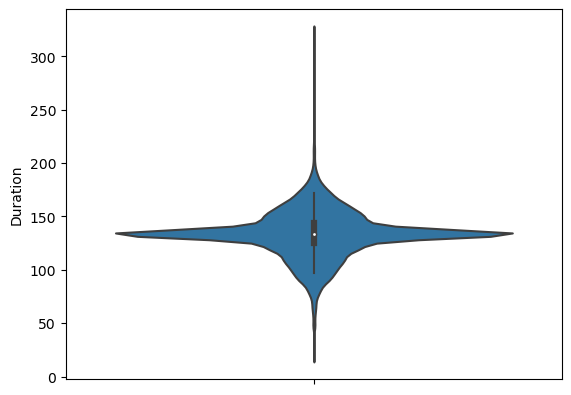

In [95]:
sns.violinplot(y=ds['Duration'])
plt.show()

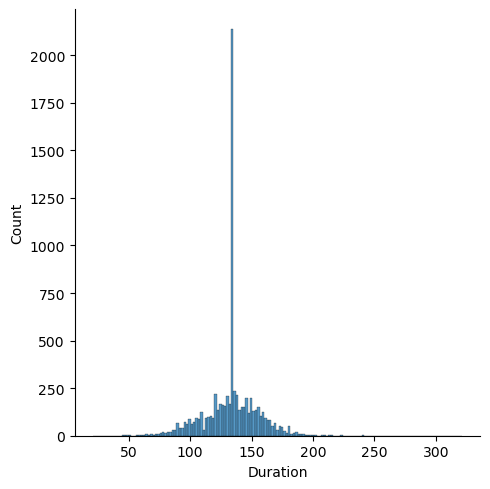

In [96]:
sns.displot(ds['Duration'])
plt.show()

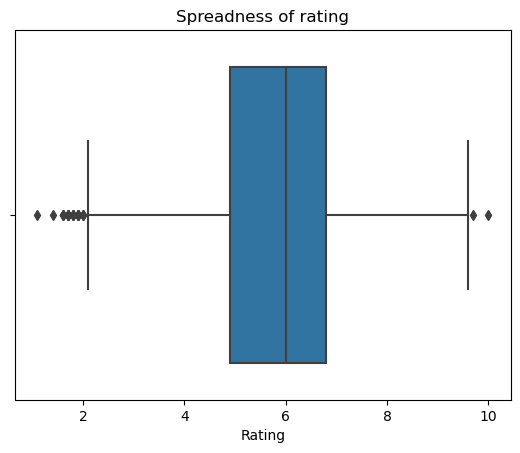

In [97]:
sns.boxplot(x=ds['Rating'])
plt.title('Spreadness of rating')
plt.show()

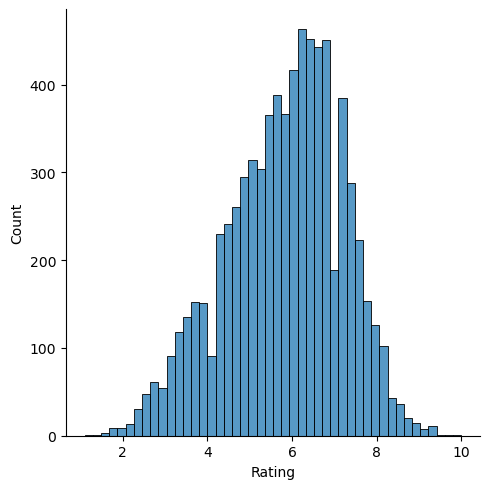

In [98]:
sns.displot(ds['Rating'])
plt.show()

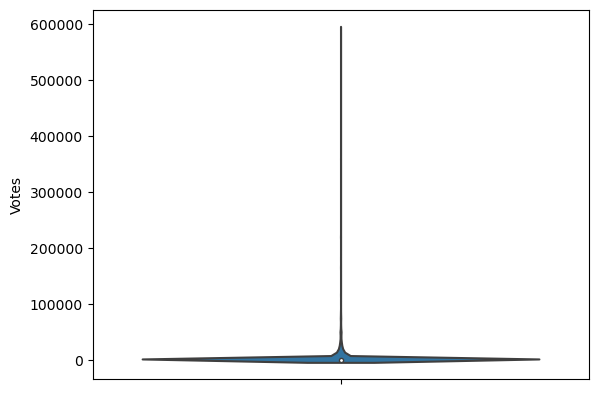

In [99]:
sns.violinplot(y=ds['Votes'])
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_1304\1389703777.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds['Votes'])


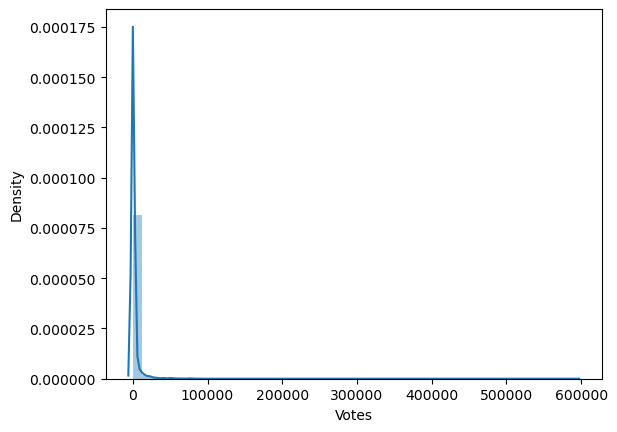

In [100]:
sns.distplot(ds['Votes'])
plt.show()

In [101]:
ds[ds['Votes']>100000]

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
75,3 Idiots,2009,170.0,"Comedy, Drama",8.4,357889,Rajkumar Hirani,Aamir Khan,Madhavan,Mona Singh
3410,Dangal,2016,161.0,"Action, Biography, Drama",8.4,165074,Nitesh Tiwari,Aamir Khan,Sakshi Tanwar,Fatima Sana Shaikh
3829,Dil Bechara,2020,101.0,"Comedy, Drama, Romance",6.6,117377,Mukesh Chhabra,Sushant Singh Rajput,Sanjana Sanghi,Sahil Vaid
4848,Gandhi,1982,191.0,"Biography, Drama, History",8.0,220118,Richard Attenborough,Ben Kingsley,John Gielgud,Rohini Hattangadi
8035,Lagaan: Once Upon a Time in India,2001,224.0,"Drama, Musical, Sport",8.1,107234,Ashutosh Gowariker,Aamir Khan,Raghuvir Yadav,Gracy Singh
8219,Life of Pi,2012,127.0,"Adventure, Drama, Fantasy",7.9,591417,Ang Lee,Suraj Sharma,Irrfan Khan,Adil Hussain
8228,Like Stars on Earth,2007,165.0,"Drama, Family",8.4,175810,Aamir Khan,Amole Gupte,Darsheel Safary,Aamir Khan
8233,Lion,2016,118.0,"Biography, Drama",8.0,220526,Garth Davis,Dev Patel,Nicole Kidman,Rooney Mara
9764,My Name Is Khan,2010,165.0,Drama,8.0,101014,Karan Johar,Shah Rukh Khan,Kajol,Sheetal Menon
10882,PK,2014,153.0,"Comedy, Drama, Musical",8.1,168150,Rajkumar Hirani,Aamir Khan,Anushka Sharma,Sanjay Dutt


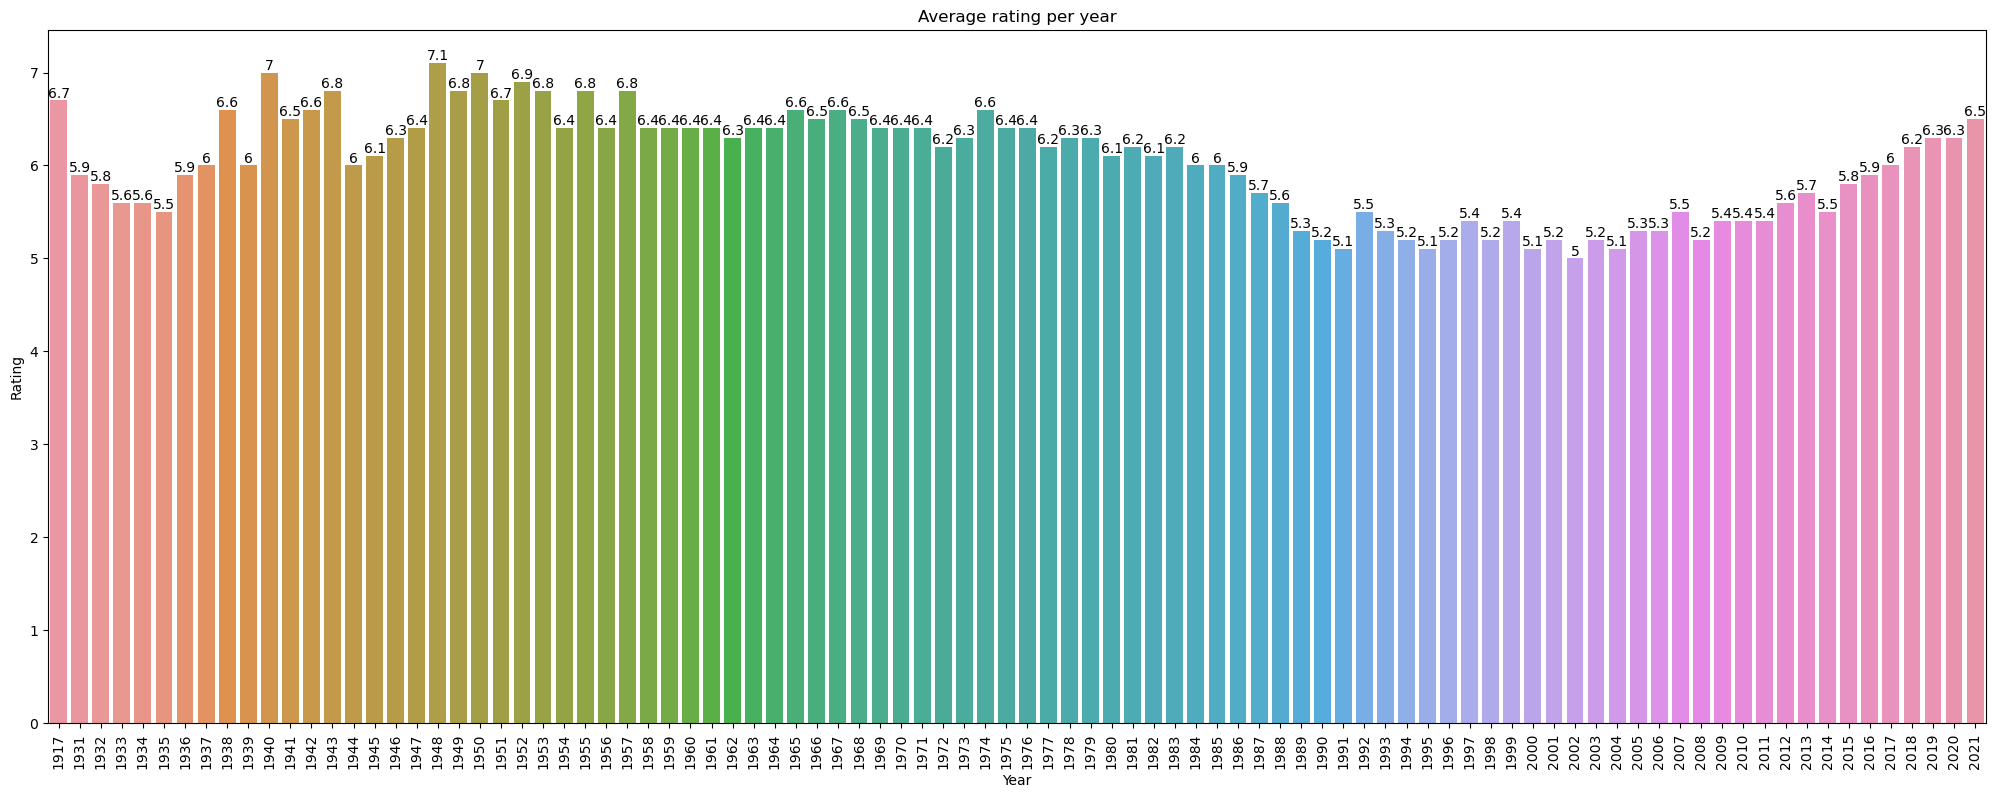

In [102]:
year_rating = ds.groupby('Year').agg({'Rating': 'mean'}).reset_index().sort_values(by='Rating',
                                                                     ascending=False,
                                                                     )
year_rating['Rating'] = round(year_rating['Rating'],1)

plt.figure(figsize=(25,9))
ax = sns.barplot(data=year_rating, x='Year', y='Rating')
ax.bar_label(ax.containers[0])
plt.title('Average rating per year')
plt.xticks(rotation=90)
plt.show()

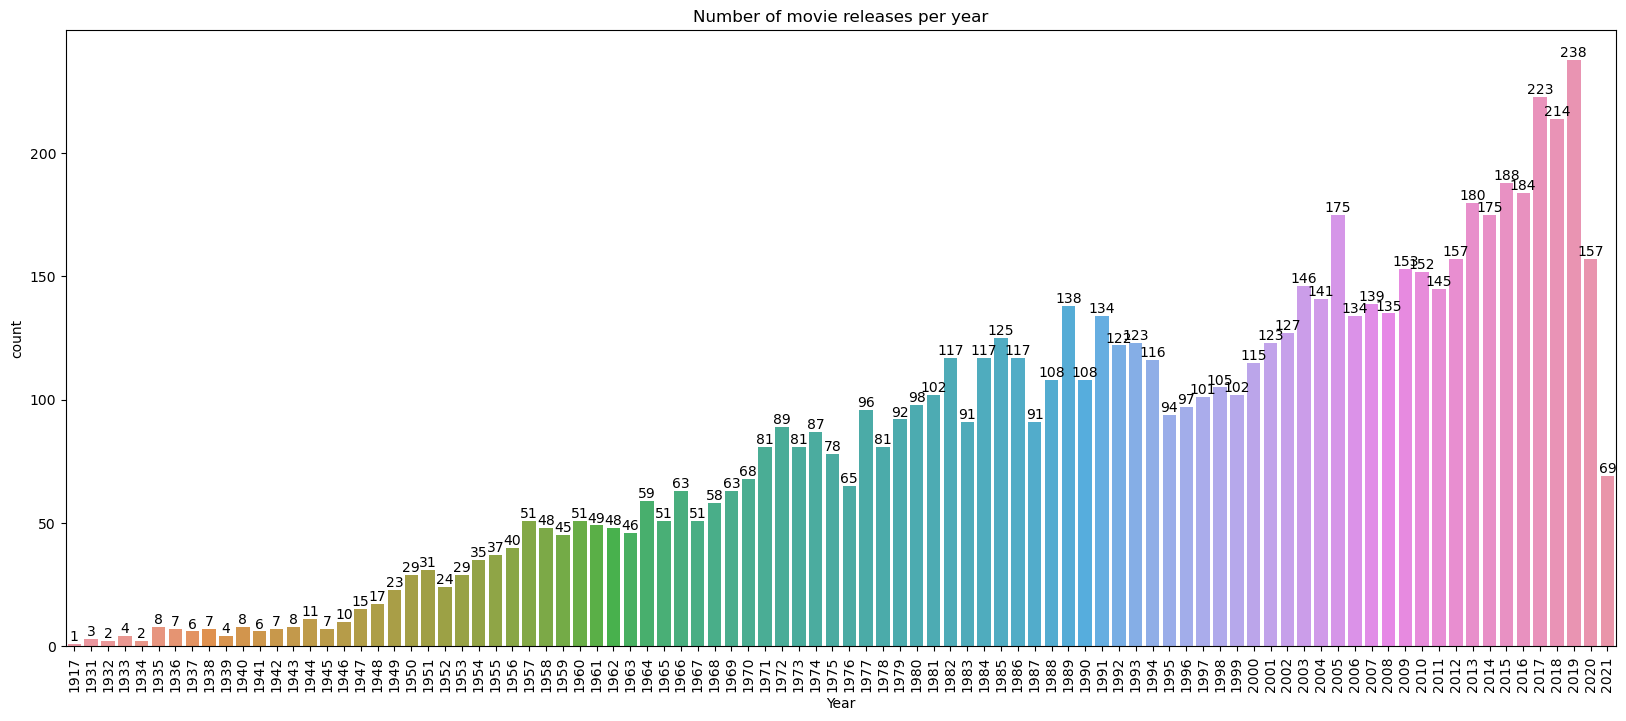

In [103]:
year_count = ds.groupby('Year').agg({'Name':'count'}).rename(columns={'Name':'count'}).\
                                        sort_values(by='count', ascending=False).reset_index()
plt.figure(figsize=(20,8))
ax = sns.barplot(data=year_count, x='Year', y='count')
ax.bar_label(ax.containers[0])
plt.title('Number of movie releases per year')
plt.xticks(rotation=90)
plt.show()

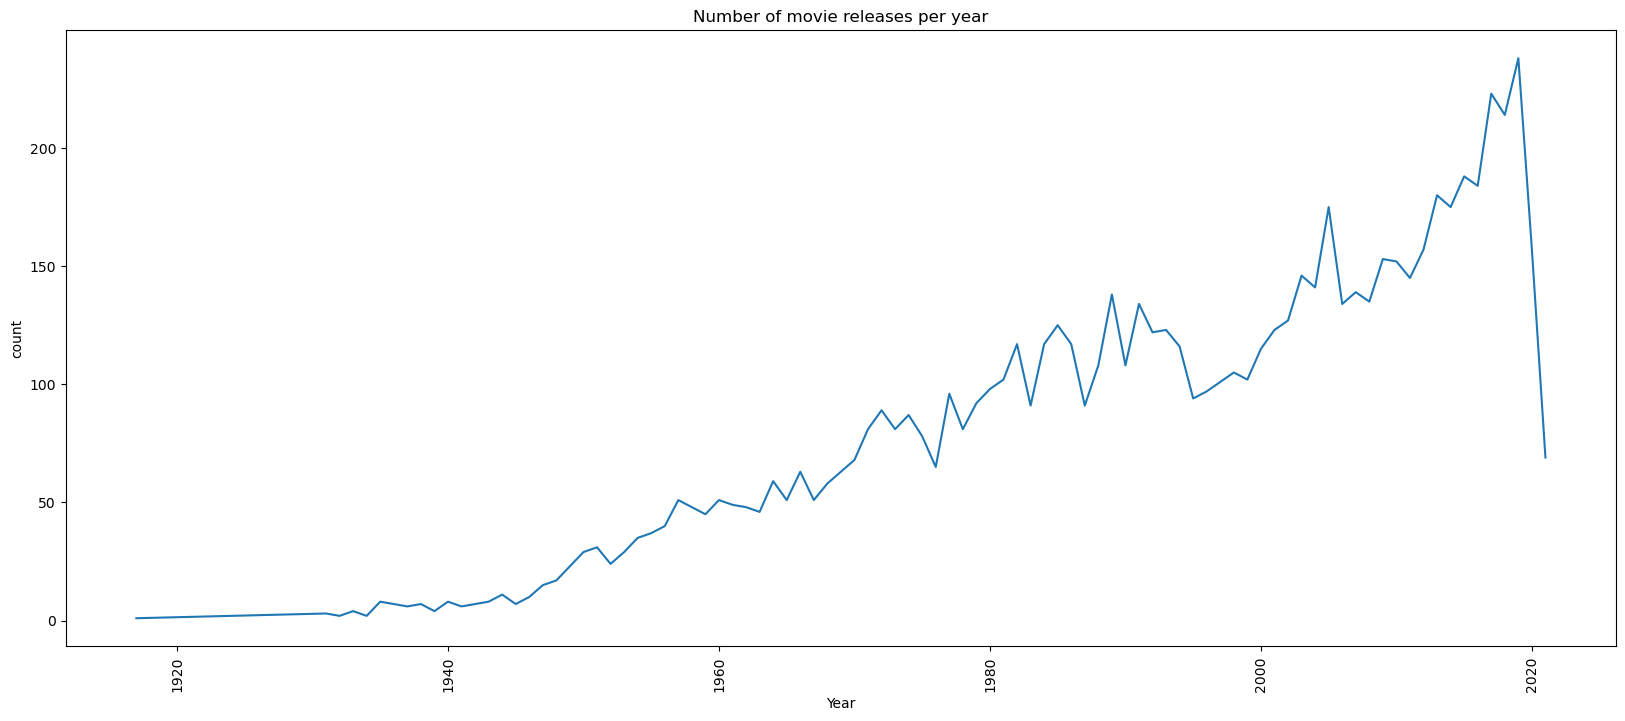

In [104]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=year_count, x='Year', y='count')
plt.title('Number of movie releases per year')
plt.xticks(rotation=90)
plt.show()

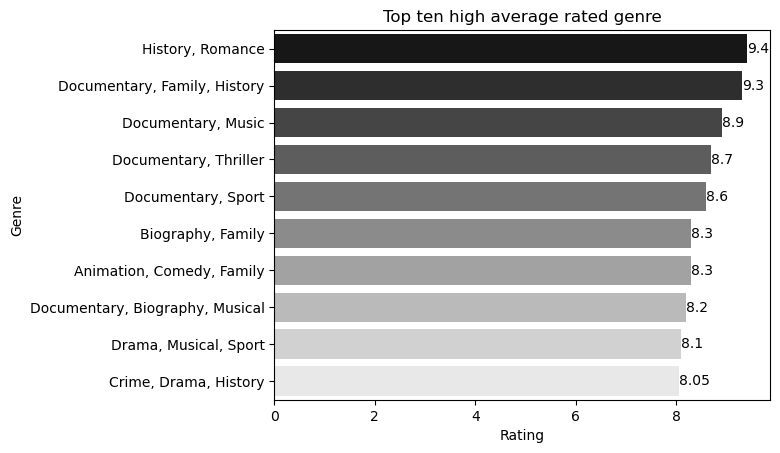

In [105]:
genre_rate = ds.groupby('Genre').agg({'Rating':'mean'}).sort_values(by='Rating', ascending=False)\
                                .reset_index().head(10)

ax = sns.barplot(data=genre_rate, x='Rating', y='Genre', palette='gist_gray')
ax.bar_label(ax.containers[0])
plt.title('Top ten high average rated genre')
plt.show()

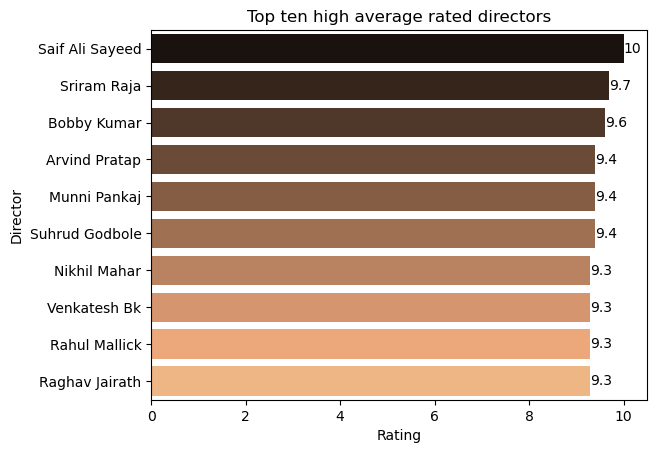

In [106]:
director_rate = ds.groupby('Director').agg({'Rating':'mean'}).sort_values(by='Rating', ascending=False)\
                                      .reset_index().head(10)

ax = sns.barplot(data=director_rate, x='Rating', y='Director', palette='copper')
ax.bar_label(ax.containers[0])
plt.title('Top ten high average rated directors')
plt.show()

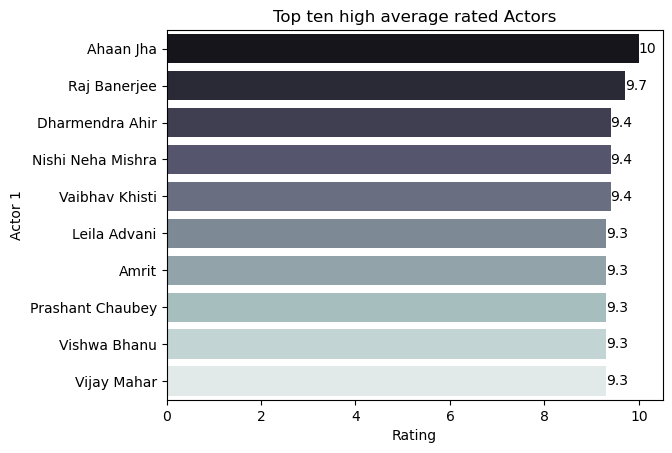

In [107]:
actor1_rate = ds.groupby('Actor 1').agg({'Rating':'mean'}).sort_values(by='Rating', ascending=False)\
                                      .reset_index().head(10)

ax = sns.barplot(data=actor1_rate, x='Rating', y='Actor 1', palette='bone')
ax.bar_label(ax.containers[0])
plt.title('Top ten high average rated Actors')
plt.show()

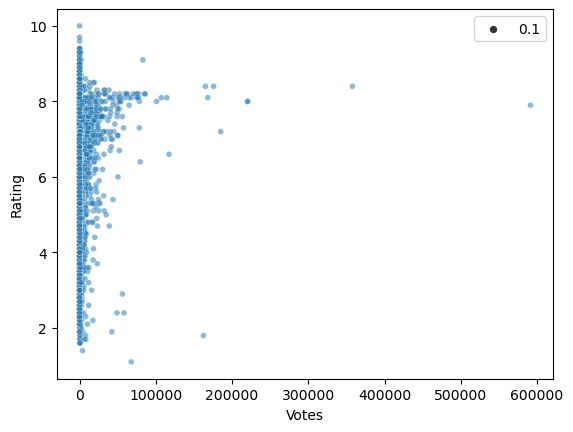

In [108]:
sns.scatterplot(data=ds, x='Votes', y='Rating', size=0.1, alpha=0.5)
plt.show()

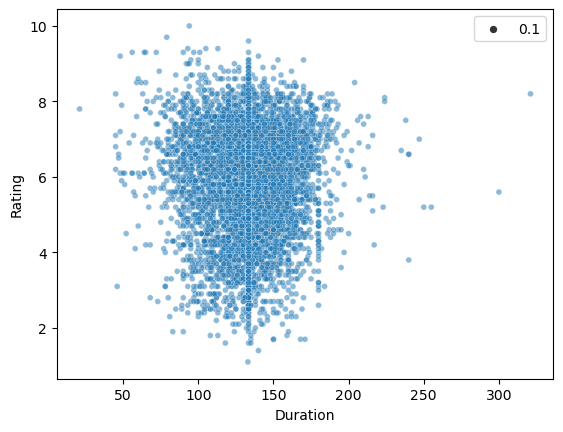

In [109]:
sns.scatterplot(data=ds, x='Duration', y='Rating', size=0.1, alpha=0.5)
plt.show()

In [ ]:
sns.pairplot(ds[['Votes', 'Rating', 'Duration']]);

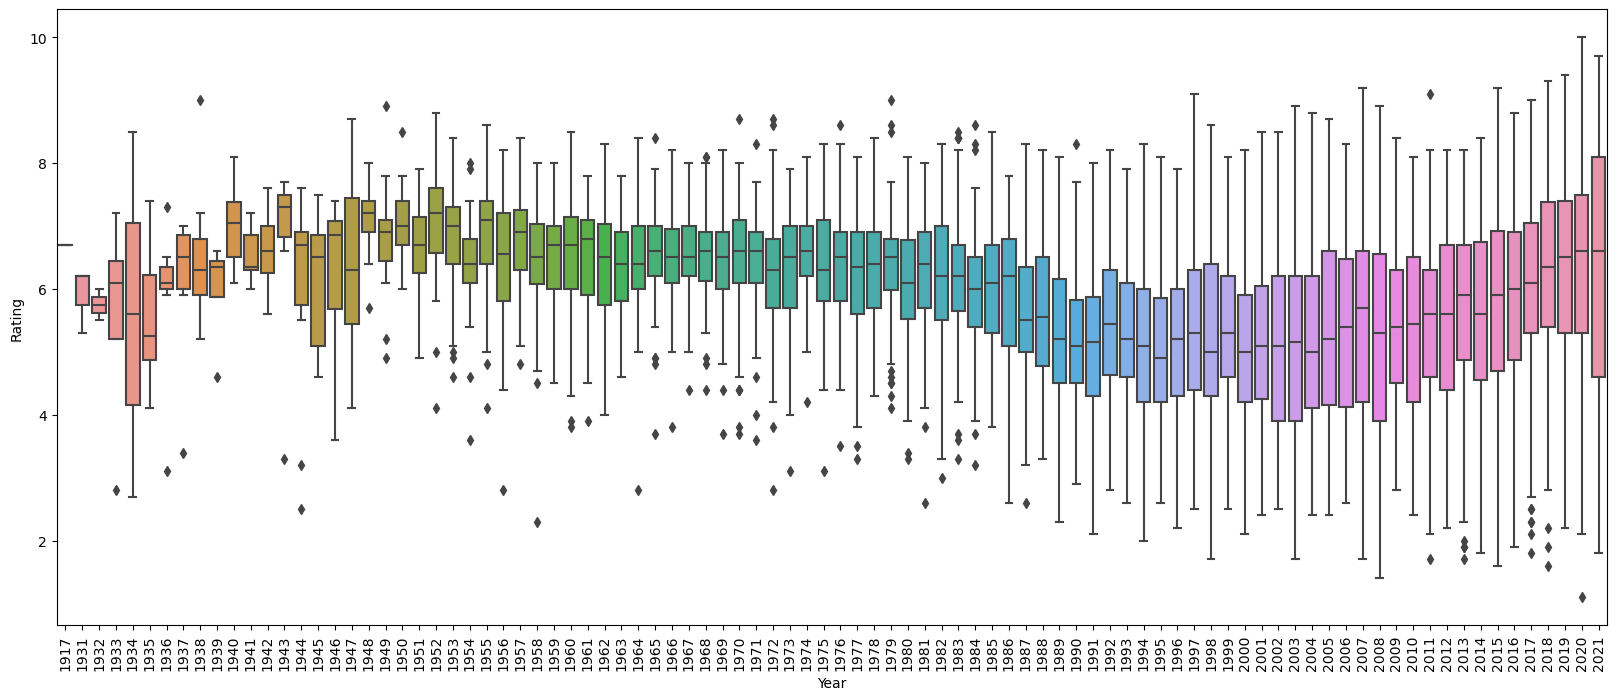

In [111]:
plt.figure(figsize=(20,8))
sns.boxplot(data=ds, x='Year', y='Rating')
plt.xticks(rotation=90)
plt.show()

In [112]:
ds_update = ds.drop(['Name'], axis=1)

In [113]:
ds_update.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7558 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      7558 non-null   int32  
 1   Duration  7558 non-null   float64
 2   Genre     7558 non-null   object 
 3   Rating    7558 non-null   float64
 4   Votes     7558 non-null   int32  
 5   Director  7558 non-null   object 
 6   Actor 1   7558 non-null   object 
 7   Actor 2   7558 non-null   object 
 8   Actor 3   7558 non-null   object 
dtypes: float64(2), int32(2), object(5)
memory usage: 531.4+ KB


In [114]:
actor1_encoding_map = ds_update.groupby('Actor 1').agg({'Rating': 'mean'}).to_dict()
actor2_encoding_map = ds_update.groupby('Actor 2').agg({'Rating': 'mean'}).to_dict()
actor3_encoding_map = ds_update.groupby('Actor 3').agg({'Rating': 'mean'}).to_dict()
director_encoding_map = ds_update.groupby('Director').agg({'Rating': 'mean'}).to_dict()
genre_encoding_map = ds_update.groupby('Genre').agg({'Rating': 'mean'}).to_dict()

In [115]:
ds_update['actor1_encoded'] = round(ds_update['Actor 1'].map(actor1_encoding_map['Rating']),1)
ds_update['actor2_encoded'] = round(ds_update['Actor 2'].map(actor2_encoding_map['Rating']),1)
ds_update['actor3_encoded'] = round(ds_update['Actor 3'].map(actor3_encoding_map['Rating']),1)
ds_update['director_encoded'] = round(ds_update['Director'].map(director_encoding_map['Rating']),1)
ds_update['genre_encoded'] = round(ds_update['Genre'].map(genre_encoding_map['Rating']),1)

In [116]:
ds_update.drop(['Actor 1', 'Actor 2', 'Actor 3', 'Director', 'Genre'], axis=1, inplace=True)
ds_update.head()

,Year,Duration,Rating,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
1,2019,109.0,7.0,8,6.8,7.0,7.0,7.0,6.3
3,2019,110.0,4.4,35,5.4,4.4,4.4,4.4,5.7
5,1997,147.0,4.7,827,4.8,5.8,5.8,5.4,6.2
6,2005,142.0,7.4,1086,5.3,6.0,6.5,7.5,6.8
8,2012,82.0,5.6,326,5.6,5.9,5.6,5.6,5.5


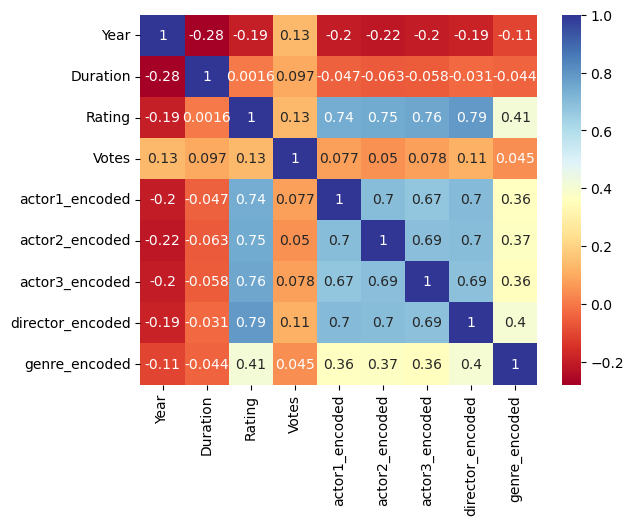

In [117]:
sns.heatmap(ds_update.corr(), annot=True, cmap='RdYlBu')
plt.show()

In [118]:
x = ds_update.drop('Rating', axis=1)
y = ds_update['Rating']

x.head()

,Year,Duration,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
1,2019,109.0,8,6.8,7.0,7.0,7.0,6.3
3,2019,110.0,35,5.4,4.4,4.4,4.4,5.7
5,1997,147.0,827,4.8,5.8,5.8,5.4,6.2
6,2005,142.0,1086,5.3,6.0,6.5,7.5,6.8
8,2012,82.0,326,5.6,5.9,5.6,5.6,5.5


In [119]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [120]:
print('Shape of training features: ', X_train.shape)
print('Shape of training target: ', y_train.shape)
print('Shape of testing features: ', X_test.shape)
print('Shape of testing target: ', y_test.shape)

Shape of training features:  (6046, 8)
Shape of training target:  (6046,)
Shape of testing features:  (1512, 8)
Shape of testing target:  (1512,)


In [121]:
LR = LinearRegression()
LR.fit(X_train, y_train)
print('Coefficient of determination: ', LR.score(X_train, y_train))

Coefficient of determination:  0.7613579123839522


In [122]:
y_pred_LR = LR.predict(X_test)

print('R^2: ', r2_score(y_test, y_pred_LR))
print('MAE: ',mean_absolute_error(y_test, y_pred_LR))
print('MSE: ', mean_squared_error(y_test, y_pred_LR))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_LR)))

R^2:  0.7580529126852418
MAE:  0.4983995226829543
MSE:  0.4482886095535747
RMSE:  0.6695435830127675


In [123]:
results = pd.DataFrame({'actual': y_test,
                        'predicted': y_pred_LR.ravel(),
                        'residual': y_test - y_pred_LR}
                      )
results.head()

,actual,predicted,residual
6241,7.4,6.617484,0.782516
3321,4.9,5.485182,-0.585182
6117,6.5,6.324062,0.175938
5975,5.7,5.552979,0.147021
6653,7.0,6.973330,0.026670


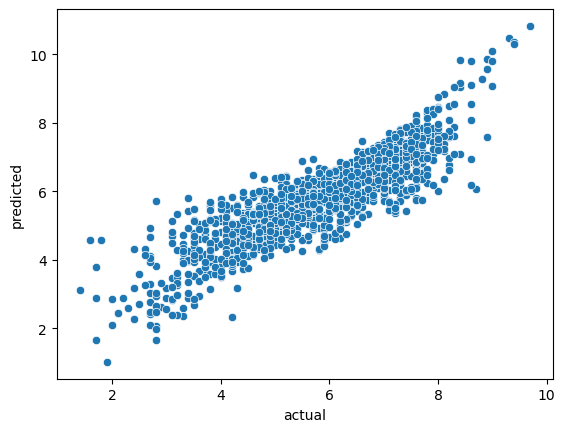

In [124]:
sns.scatterplot(x=results['actual'], y=results['predicted'])
plt.show()

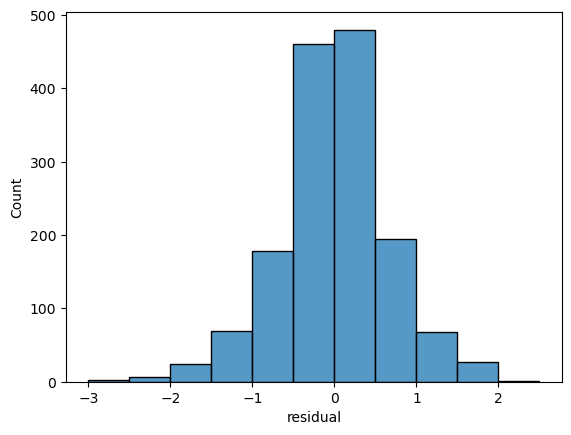

In [125]:
sns.histplot(results['residual'], bins=np.arange(-3,3,0.5))
plt.show()

In [126]:
results['residual'].mean()

-0.002914307154588724

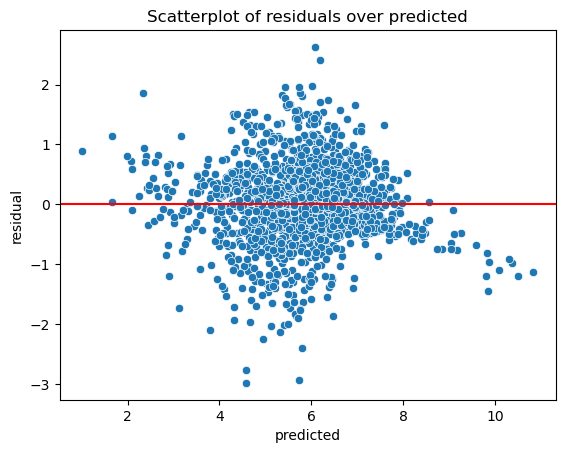

In [127]:
sns.scatterplot(x=results['predicted'], y=results['residual'])
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted')
plt.show()

In [130]:
coefficients = pd.DataFrame(LR.coef_, index=x.columns).T
coefficients

,Year,Duration,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
0,0.001163,0.003416,0.000005,0.246797,0.271906,0.337149,0.410225,0.136947


In [133]:
LR_cv = LinearRegression()

k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)  

scores = cross_val_score(LR_cv, x, y, cv=cv, scoring='r2')

print("R^2 scores:", scores)
print("Mean R^2:", scores.mean())
print("Standard Deviation of R^2:", scores.std())

R^2 scores: [0.75805291 0.7593615  0.76172776 0.75988008 0.76146141]
Mean R^2: 0.7600967351040424
Standard Deviation of R^2: 0.0013628876140524759


In [134]:
RR = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search_RR = GridSearchCV(RR, param_grid, cv=5, scoring='r2')
grid_search_RR.fit(X_train, y_train)
grid_search_RR.best_params_

{'alpha': 10}

In [135]:
y_pred_RR = grid_search_RR.predict(X_test)

print('R^2: ', r2_score(y_test, y_pred_RR))
print('MAE: ',mean_absolute_error(y_test, y_pred_RR))
print('MSE: ', mean_squared_error(y_test, y_pred_RR))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_RR)))

R^2:  0.7580764292819027
MAE:  0.4983562852139371
MSE:  0.4482450371240178
RMSE:  0.669511043317448


In [136]:
tree = DecisionTreeRegressor(random_state=0)
param_grid = {'max_depth': [None, 10, 20, 30]}
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='r2')
grid_search_tree.fit(X_train, y_train)
grid_search_tree.best_params_

{'max_depth': 10}

In [137]:
y_pred_tree = grid_search_tree.predict(X_test)
print('R^2: ', r2_score(y_test, y_pred_tree))
print('MAE: ',mean_absolute_error(y_test, y_pred_tree))
print('MSE: ', mean_squared_error(y_test, y_pred_tree))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_tree)))

R^2:  0.707626058940163
MAE:  0.5106472740736313
MSE:  0.5417213695856643
RMSE:  0.7360172345710828


In [140]:
RF = RandomForestRegressor(random_state=0)
param_grid = {'min_samples_leaf': [1, 3, 5]}
grid_search_RF = GridSearchCV(RF, param_grid, cv=5, scoring='r2')
grid_search_RF.fit(X_train, y_train)
grid_search_RF.best_params_

{'min_samples_leaf': 3}

In [139]:
y_pred_RF = grid_search_RF.predict(X_test)
print('R^2: ', r2_score(y_test, y_pred_RF))
print('MAE: ',mean_absolute_error(y_test, y_pred_RF))
print('MSE: ', mean_squared_error(y_test, y_pred_RF))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_RF)))

R^2:  0.7968416509125918
MAE:  0.4269651381450664
MSE:  0.37641938509105854
RMSE:  0.6135302642014153


## Conclusion

### 
* The years 1948, 1940 and 1950 had high average movie ratings.
* The trend of number of movie release per year has increased from 1917 to 2020.
* The top high avearge rated genres are (History, Romance), (Documentary, History, Family) and (Documentary, Music)
* The top high avearge rated directors are Saif Ali Sayeed, Sriram Raja and Bobby Kumar.
* The top high avearge rated actors are Ahaan jha, Raj Banerjee and Dharmendra Ahir.
* Movie rating and movie votes are not highly correlated.
* There is no correlation between movie rating and movie duration.
* The linear regression model resluts in R^2 of `0.758` on test data.
* The linear regression model after cross validation resluts in R^2 of `0.76`.
* The decision tree model resluts in R^2 of `0.70` on test data.
* The random forest regressor model resluts in R^2 of `0.79` on test data.